In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Stock Dataset

In [20]:
# APPLE stock data from 2006-07-18 to 2020-07-18
data = pd.read_csv('./AAPL.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-07-17,7.390000,7.587143,7.378572,7.481429,6.476653,256135600
1,2006-07-18,7.594285,7.692857,7.407143,7.557143,6.542199,250112100
2,2006-07-19,7.565714,7.868571,7.480000,7.728571,6.690604,347685800
3,2006-07-20,8.708571,8.798572,8.531428,8.642858,7.482098,493036600
4,2006-07-21,8.545714,8.735714,8.520000,8.674286,7.509306,222973100


In [21]:
# this many entries
len(data['Date'])

3525

# Plot Data

In [22]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time since 2006-07-18")
    plt.ylabel("Closing Price")
    plt.grid(True)

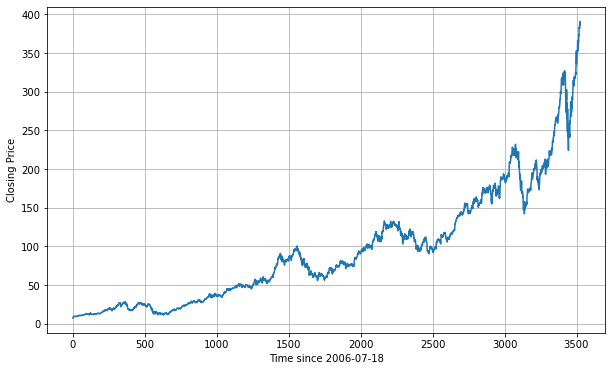

In [23]:
series = np.array(data['Close'])
time = range(len(data['Date']))
plt.figure(figsize=(10,6))
plot_series(time, series)

# Split Data

In [25]:
split_time = 3000
# use 3000 days for training and about 500 for testing
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size= 30
batch_size = 32
shuffle_buffer_size = 1000

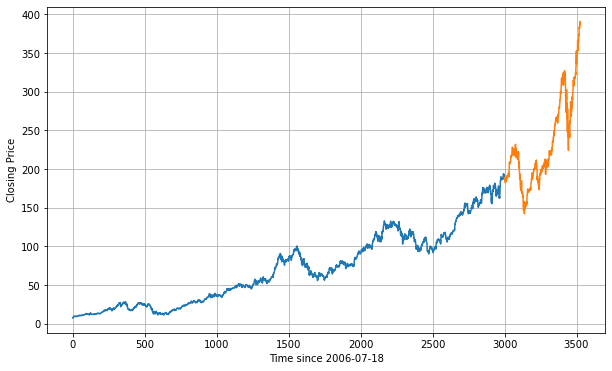

In [31]:
plt.figure(figsize=(10,6))
# blue is training, orange is testing
plot_series(time_train, x_train)
plot_series(time_valid, x_valid)

# Data Training Format

In [32]:
# create a windowed dataset which we will use to train the network later
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# First Model Attempt

In [36]:
window_size = 64
batch_size = 256
# get the training data
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [37]:
# create a model with LSTMs
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# find a good learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# compile and run the model
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 2s 185ms/step - loss: 128.3927 - mae: 128.8927 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 2s 168ms/step - loss: 126.2727 - mae: 126.7727 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 2s 172ms/step - loss: 123.1613 - mae: 123.6613 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 2s 188ms/step - loss: 119.4668 - mae: 119.9668 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 2s 204ms/step - loss: 115.2785 - mae: 115.7784 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 2s 174ms/step - loss: 110.5718 - mae: 111.0717 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 2s 177ms/step - loss: 105.3791 - mae: 105.8790 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 2s 176ms/step - loss: 99.9716 - mae: 100.4715 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 2s 171ms/ste

12/12 [==============================] - 2s 188ms/step - loss: 27.1848 - mae: 27.6809 - lr: 3.1623e-05
Epoch 72/100
12/12 [==============================] - 3s 239ms/step - loss: 32.3529 - mae: 32.8500 - lr: 3.5481e-05
Epoch 73/100
12/12 [==============================] - 3s 214ms/step - loss: 18.5847 - mae: 19.0785 - lr: 3.9811e-05
Epoch 74/100
12/12 [==============================] - 2s 180ms/step - loss: 20.2682 - mae: 20.7628 - lr: 4.4668e-05
Epoch 75/100
12/12 [==============================] - 2s 170ms/step - loss: 29.2070 - mae: 29.7038 - lr: 5.0119e-05
Epoch 76/100
12/12 [==============================] - 2s 180ms/step - loss: 31.9755 - mae: 32.4721 - lr: 5.6234e-05
Epoch 77/100
12/12 [==============================] - 2s 185ms/step - loss: 31.0639 - mae: 31.5621 - lr: 6.3096e-05
Epoch 78/100
12/12 [==============================] - 2s 186ms/step - loss: 14.5833 - mae: 15.0744 - lr: 7.0795e-05
Epoch 79/100
12/12 [==============================] - 2s 184ms/step - loss: 38.7346 -

(1e-08, 0.0001, 0.0, 60.0)

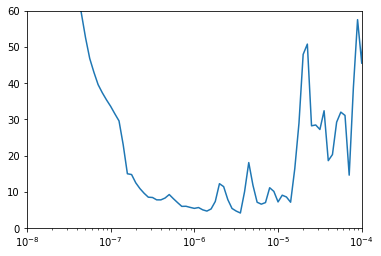

In [38]:
# plot a graph to pick out the best learning rate
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

# Second Model Attempt

In [39]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

# same model but this time with a better learning rate
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# learning rate corresponds to lowest value in the graph above
optimizer = tf.keras.optimizers.SGD(lr=2e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 101ms/step - loss: 20.3671 - mae: 20.8594
Epoch 2/500
30/30 [==============================] - 3s 101ms/step - loss: 7.6313 - mae: 8.1076
Epoch 3/500
30/30 [==============================] - 3s 99ms/step - loss: 5.9540 - mae: 6.4224
Epoch 4/500
30/30 [==============================] - 3s 99ms/step - loss: 5.0435 - mae: 5.5083
Epoch 5/500
30/30 [==============================] - 3s 100ms/step - loss: 4.2362 - mae: 4.6957
Epoch 6/500
30/30 [==============================] - 3s 96ms/step - loss: 3.9625 - mae: 4.4180
Epoch 7/500
30/30 [==============================] - 3s 98ms/step - loss: 4.6030 - mae: 5.0692
Epoch 8/500
30/30 [==============================] - 3s 98ms/step - loss: 4.1990 - mae: 4.6649
Epoch 9/500
30/30 [==============================] - 3s 105ms/step - loss: 3.3814 - mae: 3.8343
Epoch 10/500
30/30 [==============================] - 3s 102ms/step - loss: 3.0433 - mae: 3.4909
Epoch 11/500
30/30 [======================

30/30 [==============================] - 4s 125ms/step - loss: 1.7792 - mae: 2.2214
Epoch 86/500
30/30 [==============================] - 4s 122ms/step - loss: 1.2700 - mae: 1.6903
Epoch 87/500
30/30 [==============================] - 4s 122ms/step - loss: 1.2623 - mae: 1.6764
Epoch 88/500
30/30 [==============================] - 4s 122ms/step - loss: 1.2393 - mae: 1.6537
Epoch 89/500
30/30 [==============================] - 4s 132ms/step - loss: 1.3670 - mae: 1.7979
Epoch 90/500
30/30 [==============================] - 3s 116ms/step - loss: 1.4026 - mae: 1.8185
Epoch 91/500
30/30 [==============================] - 4s 131ms/step - loss: 1.5515 - mae: 1.9872
Epoch 92/500
30/30 [==============================] - 4s 132ms/step - loss: 1.3692 - mae: 1.7980
Epoch 93/500
30/30 [==============================] - 4s 127ms/step - loss: 1.4919 - mae: 1.9297
Epoch 94/500
30/30 [==============================] - 4s 122ms/step - loss: 1.2335 - mae: 1.6496
Epoch 95/500
30/30 [=======================

30/30 [==============================] - 4s 119ms/step - loss: 1.0084 - mae: 1.4115
Epoch 169/500
30/30 [==============================] - 4s 117ms/step - loss: 1.0695 - mae: 1.4776
Epoch 170/500
30/30 [==============================] - 3s 116ms/step - loss: 1.2738 - mae: 1.6986
Epoch 171/500
30/30 [==============================] - 4s 119ms/step - loss: 1.1807 - mae: 1.5988
Epoch 172/500
30/30 [==============================] - 4s 135ms/step - loss: 1.5191 - mae: 1.9588
Epoch 173/500
30/30 [==============================] - 4s 148ms/step - loss: 0.9860 - mae: 1.3838 0s - loss: 0.8727 - mae: 
Epoch 174/500
30/30 [==============================] - 5s 158ms/step - loss: 1.0800 - mae: 1.4976
Epoch 175/500
30/30 [==============================] - 4s 142ms/step - loss: 0.9838 - mae: 1.3833
Epoch 176/500
30/30 [==============================] - 4s 117ms/step - loss: 1.0361 - mae: 1.4440
Epoch 177/500
30/30 [==============================] - 4s 121ms/step - loss: 1.2004 - mae: 1.6240
Epoch 17

30/30 [==============================] - 5s 153ms/step - loss: 0.9303 - mae: 1.3303
Epoch 251/500
30/30 [==============================] - 5s 151ms/step - loss: 1.0300 - mae: 1.4432
Epoch 252/500
30/30 [==============================] - 5s 153ms/step - loss: 1.1488 - mae: 1.5737
Epoch 253/500
30/30 [==============================] - 4s 123ms/step - loss: 0.8846 - mae: 1.2737
Epoch 254/500
30/30 [==============================] - 3s 105ms/step - loss: 0.9263 - mae: 1.3260
Epoch 255/500
30/30 [==============================] - 5s 151ms/step - loss: 0.9725 - mae: 1.3770
Epoch 256/500
30/30 [==============================] - 5s 152ms/step - loss: 0.9820 - mae: 1.3775
Epoch 257/500
30/30 [==============================] - 4s 150ms/step - loss: 0.9878 - mae: 1.3967
Epoch 258/500
30/30 [==============================] - 5s 150ms/step - loss: 1.0757 - mae: 1.4977
Epoch 259/500
30/30 [==============================] - 5s 153ms/step - loss: 1.1687 - mae: 1.5955
Epoch 260/500
30/30 [=============

30/30 [==============================] - 5s 152ms/step - loss: 0.8907 - mae: 1.2895
Epoch 332/500
30/30 [==============================] - 5s 152ms/step - loss: 0.9725 - mae: 1.3787
Epoch 333/500
30/30 [==============================] - 5s 152ms/step - loss: 0.7698 - mae: 1.1499
Epoch 334/500
30/30 [==============================] - 5s 151ms/step - loss: 0.8867 - mae: 1.2921
Epoch 335/500
30/30 [==============================] - 5s 152ms/step - loss: 0.8058 - mae: 1.1878
Epoch 336/500
30/30 [==============================] - 5s 151ms/step - loss: 0.8449 - mae: 1.2415
Epoch 337/500
30/30 [==============================] - 4s 150ms/step - loss: 0.8840 - mae: 1.2821
Epoch 338/500
30/30 [==============================] - 5s 152ms/step - loss: 0.8194 - mae: 1.2020
Epoch 339/500
30/30 [==============================] - 5s 155ms/step - loss: 0.8828 - mae: 1.2881
Epoch 340/500
30/30 [==============================] - 5s 153ms/step - loss: 0.8751 - mae: 1.2753
Epoch 341/500
30/30 [=============

30/30 [==============================] - 4s 149ms/step - loss: 0.8696 - mae: 1.2693
Epoch 415/500
30/30 [==============================] - 4s 148ms/step - loss: 0.7645 - mae: 1.1463
Epoch 416/500
30/30 [==============================] - 4s 147ms/step - loss: 0.9431 - mae: 1.3552
Epoch 417/500
30/30 [==============================] - 4s 148ms/step - loss: 0.8095 - mae: 1.2037
Epoch 418/500
30/30 [==============================] - 4s 147ms/step - loss: 0.8180 - mae: 1.2146
Epoch 419/500
30/30 [==============================] - 4s 148ms/step - loss: 0.8208 - mae: 1.2093
Epoch 420/500
30/30 [==============================] - 4s 142ms/step - loss: 0.7798 - mae: 1.1565
Epoch 421/500
30/30 [==============================] - 4s 143ms/step - loss: 0.8361 - mae: 1.2345
Epoch 422/500
30/30 [==============================] - 4s 148ms/step - loss: 0.7994 - mae: 1.1861
Epoch 423/500
30/30 [==============================] - 4s 150ms/step - loss: 0.8843 - mae: 1.2884
Epoch 424/500
30/30 [=============

30/30 [==============================] - 4s 138ms/step - loss: 0.8316 - mae: 1.2311
Epoch 498/500
30/30 [==============================] - 3s 98ms/step - loss: 0.7471 - mae: 1.1288
Epoch 499/500
30/30 [==============================] - 5s 153ms/step - loss: 0.9071 - mae: 1.3126
Epoch 500/500
30/30 [==============================] - 5s 162ms/step - loss: 0.7891 - mae: 1.1839


# Showcase Results

In [41]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [42]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

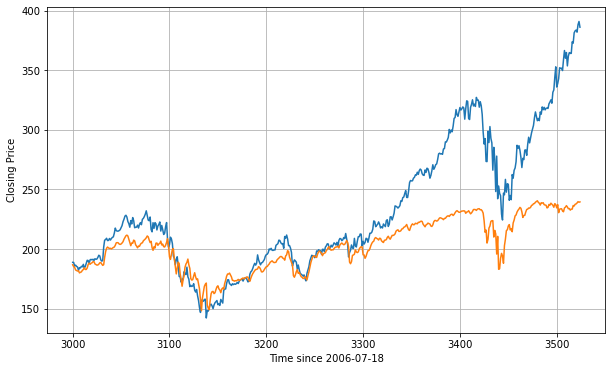

In [43]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [44]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

30.495674